Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

# Automated Machine Learning
**BikeShare Demand Forecasting**

## Contents
1. [Introduction](#Introduction)
1. [Setup](#Setup)
1. [Data](#Data)
1. [Compute](#Compute)
1. [Configure and run](#Train)
1. [Retrieve the Best Trial](#Train)
1. [Train](#Train)
1. [Featurization](#Featurization)
1. [Forecasting using batch endpoint](Train)
1. [Evaluate](#Evaluate)

## 1. Introduction
This notebook demonstrates demand forecasting for a bike-sharing service using AutoML.

AutoML highlights include built-in holiday featurization, accessing engineered feature names, and working with the `forecast` function. Please also look at the additional forecasting notebooks, which document lagging, rolling windows, forecast quantiles, other ways to use the forecast function, and forecaster deployment.

Make sure you have executed the [configuration notebook](../../../configuration.ipynb) before running this notebook.

Notebook synopsis:
1. Creating an Experiment in an existing Workspace
2. Configuration and local run of AutoML for a time-series model with lag and holiday features 
3. Viewing the engineered names for featurized data and featurization summary for all raw features
4. Evaluating the fitted model using a rolling test

## 2. Setup

#### Import the required libraries


In [1]:
# Import required libraries
from azure.identity import DefaultAzureCredential
from azure.ai.ml import MLClient
from azure.ai.ml.constants import AssetTypes
from azure.ai.ml import automl
from azure.ai.ml import Input

import json
import logging
from datetime import datetime
import numpy as np
import pandas as pd

#### Connect to Azure Machine Learning Workspace

The [workspace](https://docs.microsoft.com/en-us/azure/machine-learning/concept-workspace) is the top-level resource for Azure Machine Learning, providing a centralized place to work with all the artifacts you create when you use Azure Machine Learning. In this section we will connect to the workspace in which the job will be run.

This notebook is compatible with Azure ML SDK version 1.35.0 or later.

As part of the setup you have already created a <b>Workspace</b>. To run AutoML, you also need to create an <b>Experiment</b>. An Experiment corresponds to a prediction problem you are trying to solve, while a Run corresponds to a specific approach to the problem.

In [2]:
credential = DefaultAzureCredential()
ml_client = None
try:
    ml_client = MLClient.from_config(credential)
except Exception as ex:
    print(ex)
    # Enter details of your AML workspace
    subscription_id = "<SUBSCRIPTION_ID>"
    resource_group =  "<RESOURCE_GROUP>"
    workspace =  "<AML_WORKSPACE_NAME>"
    
    ml_client = MLClient(credential, subscription_id, resource_group, workspace)

We could not find config.json in: . or in its parent directories. Please provide the full path to the config file or ensure that config.json exists in the parent directories.


#### Show Azure ML Workspace information

In [3]:
import pandas as pd

workspace = ml_client.workspaces.get(name=ml_client.workspace_name)

output = {}
output["Workspace"] = ml_client.workspace_name
output["Subscription ID"] = ml_client.connections._subscription_id
output["Resource Group"] = workspace.resource_group
output["Location"] = workspace.location
pd.set_option("display.max_colwidth", None)
outputDf = pd.DataFrame(data=output, index=[""])
outputDf.T

,
Workspace,test
Subscription ID,381b38e9-9840-4719-a5a0-61d9585e1e91
Resource Group,sagoswami_southcentralus_rg
Location,eastus2


## 3. Data

The [Machine Learning service workspace](https://docs.microsoft.com/en-us/azure/machine-learning/service/concept-workspace) is paired with the storage account, which contains the default data store. We will use it to upload the bike share data and create [tabular dataset](https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.data.tabulardataset?view=azure-ml-py) for training. A tabular dataset defines a series of lazily-evaluated, immutable operations to load data from the data source into tabular representation.

With Azure Machine Learning MLTables you can keep a single copy of data in your storage, easily access data during model training, share data and collaborate with other users. 
Below, we will upload the data by creating an MLTable to be used for training.

**NOTE:** In this PRIVATE PREVIEW we're defining the MLTable in a separate folder and .YAML file.
In later versions, you'll be able to do it all in Python APIs.

In [4]:
# Training MLTable defined locally, with local data to be uploaded
my_training_data_input = Input(
    type=AssetTypes.MLTABLE, path="./data/training-mltable-folder"
)

# WITH REMOTE PATH
# my_training_data_input  = Input(type=AssetTypes.MLTABLE, path="azureml://datastores/workspaceblobstore/paths/my-forecasting-mltable")

In [5]:
import os
import shutil

os.makedirs("test_dataset", exist_ok=True)
shutil.copy(
    "data/test-mltable-folder/bike-no-test.csv",
    "test_dataset/bike-no-test.csv",
)

my_test_data_input = Input(
    type=AssetTypes.URI_FOLDER,
    path="test_dataset/",
)

We will upload the dirrectory with the test set so that further we will be able to run the inferencing on the batch endpoint.

## 4. Compute
#### Create or Attach existing AmlCompute.
[Azure Machine Learning Compute](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-set-up-training-targets#amlcompute) is a managed-compute infrastructure that allows the user to easily create a single or multi-node compute. In this tutorial, you create AmlCompute as your training compute resource.

##### Creation of AmlCompute takes approximately 5 minutes. 
If the AmlCompute with that name is already in your workspace this code will skip the creation process.
As with other Azure services, there are limits on certain resources (e.g. AmlCompute) associated with the Azure Machine Learning service. Please read [this article](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-manage-quotas) on the default limits and how to request more quota.

In [8]:
from azure.core.exceptions import ResourceNotFoundError
from azure.ai.ml.entities import AmlCompute

cluster_name = "bike-share-v2"

try:
    # Retrieve an already attached Azure Machine Learning Compute.
    compute = ml_client.compute.get(cluster_name)
except ResourceNotFoundError as e:
    compute = AmlCompute(
        name=cluster_name,
        size="STANDARD_DS12_V2",
        type="amlcompute",
        min_instances=0,
        max_instances=4,
        idle_time_before_scale_down=120,
    )
    poller = ml_client.begin_create_or_update(compute)
    poller.wait()

## 5. Configure and run the AutoML Forecasting training job
In this section we will configure and run the AutoML job, for training the model.

### Configure the job through the forecasting() factory function

#### forecasting() function parameters:

The `forecasting()` factory function allows user to configure AutoML for the forecasting task for the most common scenarios with the following properties.

|Property|Description|
|-|-|
|**target_column_name**|The name of the label column.|
|**primary_metric**|This is the metric that you want to optimize.<br> Forecasting supports the following primary metrics <br><i>spearman_correlation</i><br><i>normalized_root_mean_squared_error</i><br><i>r2_score</i><br><i>normalized_mean_absolute_error</i>|
|**training_data**|The training data to be used within the experiment. You can use a registered MLTable in the workspace using the format '&lt;mltable_name&gt;:&lt;version\&gt;' OR you can use a local file or folder as a MLTable. For e.g Input(mltable='my_mltable:1') OR Input(mltable=MLTable(local_path="./data")) The parameter 'training_data' must always be provided.|
|**compute**|The compute on which the AutoML job will run. In this example we are using a compute called 'cpu-cluster' present in the workspace. You can replace it any other compute in the workspace.|
|**n_cross_validations**|Number of cross-validation folds to use for model/pipeline selection. The default value is "auto", in which case AutoMl determines the number of cross-validations automatically, if a validation set is not provided. Or users could specify an integer value.|
|**name**|The name of the Job/Run. This is an optional property. If not specified, a random name will be generated.
|**experiment_name**|The name of the Experiment. An Experiment is like a folder with multiple runs in Azure ML Workspace that should be related to the same logical machine learning experiment.|
|**enable_model_explainability**|If set to true, the explanations for the best model will be generated.|

### set_limits() parameters:
This is an optional configuration method to configure limits parameters such as timeouts.

|Property|Description|
|-|-|
|**timeout_minutes**|Maximum amount of time in minutes that the whole AutoML job can take before the job terminates. This timeout includes setup, featurization and training runs but does not include the ensembling and model explainability runs at the end of the process since those actions need to happen once all the trials (children jobs) are done. If not specified, the default job's total timeout is 6 days (8,640 minutes). To specify a timeout less than or equal to 1 hour (60 minutes), make sure your dataset's size is not greater than 10,000,000 (rows times column) or an error results.|
|**trial_timeout_minutes**|Maximum time in minutes that each trial (child job) can run for before it terminates. If not specified, a value of 1 month or 43200 minutes is used.|
|**max_trials**|The maximum number of trials/runs each with a different combination of algorithm and hyperparameters to try during an AutoML job. If not specified, the default is 1000 trials. If using 'enable_early_termination' the number of trials used can be smaller.|
|**max_concurrent_trials**|Represents the maximum number of trials (children jobs) that would be executed in parallel. It's a good practice to match this number with the number of nodes your cluster.|
|**enable_early_termination**|Whether to enable early termination if the score is not improving in the short term.|

### Specialized Forecasting Parameters
To define forecasting parameters for your experiment training, you can leverage the .set_forecast_settings() method. 
The table below details the forecasting parameters we will be passing into our experiment.

|Property|Description|
|-|-|
|**time_column_name**|The name of your time column.|
|**forecast_horizon**|The forecast horizon is how many periods forward you would like to forecast. This integer horizon is in units of the timeseries frequency (e.g. daily, weekly).|
|**frequency**|Forecast frequency. This optional parameter represents the period with which the forecast is desired, for example, daily, weekly, yearly, etc. Use this parameter for the correction of time series containing irregular data points or for padding of short time series. The frequency needs to be a pandas offset alias. Please refer to [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects) for more information.
|**cv_step_size**|Number of periods between two consecutive cross-validation folds. The default value is "auto", in which case AutoMl determines the cross-validation step size automatically, if a validation set is not provided. Or users could specify an integer value.|
|**target_lags**|The target_lags specifies how far back we will construct the lags of the target variable.|
|**target_rolling_window_size**|The target_rolling_window_size specifies the size of a rolling window for aggregated lookback features.|

### Using lags and rolling window features
This training is also using the **target lags**, that is the previous values of the target variables, meaning the prediction uses a horizon. We therefore must still specify the `forecast_horizon` that the model will learn to forecast. The `target_lags` keyword specifies how far back we will construct the lags of the target variable, and the `target_rolling_window_size` specifies the size of the rolling window over which we will generate the `max`, `min` and `sum` features.

This notebook uses the .set_training(blocked_training_algorithms=...) parameter to exclude some models that take a longer time to train on this dataset.  You can choose to remove models from the blocked_training_algorithms list but you may need to increase the trial_timeout_minutes parameter value to get results.

Let's set up what we know about the dataset. 

**Target column** is what we want to forecast.

**Time column** is the time axis along which to predict.

In [13]:
# general job parameters
max_trials = 5
exp_name = "dpv2-bike-test" #forecasting-experiment"
target_column_name = "cnt"
time_column_name = "date"

### Setting forecaster maximum horizon 

The forecast horizon is the number of periods into the future that the model should predict. Here, we set the horizon to 14 periods (i.e. 14 days). Notice that this is much shorter than the number of days in the test set; we will need to use a rolling test to evaluate the performance on the whole test set. For more discussion of forecast horizons and guiding principles for setting them, please see the [energy demand notebook](https://github.com/Azure/MachineLearningNotebooks/tree/master/how-to-use-azureml/automated-machine-learning/forecasting-energy-demand).  

In [14]:
forecast_horizon = 14

In [15]:
# Create the AutoML forecasting job with the related factory-function. Force the target column, to be integer type (To be added in phase 2)
forecasting_job = automl.forecasting(
    compute=cluster_name,
    experiment_name=exp_name,
    training_data=my_training_data_input,
    target_column_name=target_column_name,
    primary_metric="NormalizedRootMeanSquaredError",
    n_cross_validations=3,
    enable_model_explainability=True,
)

# Limits are all optional
forecasting_job.set_limits(
    timeout_minutes=60,
    trial_timeout_minutes=20, 
    max_trials=max_trials,
    enable_early_termination=True,
    max_concurrent_trials=4,
)

# Specialized properties for Time Series Forecasting training
forecasting_job.set_forecast_settings(
    time_column_name=time_column_name,
    forecast_horizon=forecast_horizon,
    frequency="D",
    # target_lags="auto", 
    country_or_region_for_holidays="US",
    # enable_stack_ensemble=False,
    target_rolling_window_size=4,
    cv_step_size=1, # it should be auto
    #n_cross_validations="auto" #
)

# Training properties are optional
forecasting_job.set_training(blocked_training_algorithms=["ExtremeRandomTrees"])

### Run the Command
Using the `MLClient` created earlier, we will now run this Command in the workspace.

In [16]:
# Submit the AutoML job
returned_job = ml_client.jobs.create_or_update(
    forecasting_job
)  # submit the job to the backend

print(f"Created job: {returned_job}")

Created job: ForecastingJob({'log_verbosity': <LogVerbosity.INFO: 'Info'>, 'target_column_name': 'cnt', 'weight_column_name': None, 'validation_data_size': None, 'cv_split_column_names': None, 'n_cross_validations': 3, 'test_data_size': None, 'task_type': <TaskType.FORECASTING: 'Forecasting'>, 'training_data': {'type': 'mltable', 'path': 'azureml://datastores/workspaceblobstore/paths/LocalUpload/748d28efc669782d68ccf2f23d2606f4/training-mltable-folder'}, 'validation_data': {'type': 'mltable'}, 'test_data': None, 'environment_id': None, 'environment_variables': None, 'outputs': {}, 'type': 'automl', 'status': 'NotStarted', 'log_files': None, 'name': 'ashy_dress_hk01dmsq4r', 'description': None, 'tags': {}, 'properties': {'mlflow.source.git.repoURL': 'https://github.com/Azure/azureml-examples.git', 'mlflow.source.git.branch': 'sagoswami/update_bike_share_v2', 'mlflow.source.git.commit': '0f24cd792e856ea35e1399a455b1cd8e7e495eec', 'azureml.git.dirty': 'True'}, 'id': '/subscriptions/381b38

In [17]:
# Wait until AutoML training runs are finished
ml_client.jobs.stream(returned_job.name)

RunId: ashy_dress_hk01dmsq4r
Web View: https://ml.azure.com/runs/ashy_dress_hk01dmsq4r?wsid=/subscriptions/381b38e9-9840-4719-a5a0-61d9585e1e91/resourcegroups/sagoswami_southcentralus_rg/workspaces/test

Execution Summary
RunId: ashy_dress_hk01dmsq4r
Web View: https://ml.azure.com/runs/ashy_dress_hk01dmsq4r?wsid=/subscriptions/381b38e9-9840-4719-a5a0-61d9585e1e91/resourcegroups/sagoswami_southcentralus_rg/workspaces/test



## 6. Retrieve the Best Trial (Best Model's trial/run)
Use the MLFLowClient to access the results (such as Models, Artifacts, Metrics) of a previously completed AutoML Trial.

### Initialize MLFlow Client
The models and artifacts that are produced by AutoML can be accessed via the MLFlow interface. Initialize the MLFlow client here, and set the backend as Azure ML, via. the MLFlow Client.

*IMPORTANT*, you need to have installed the latest MLFlow packages with:

    pip install azureml-mlflow
    pip install mlflow


#### Obtain the tracking URI for MLFlow

In [18]:
import mlflow

# Obtain the tracking URL from MLClient
MLFLOW_TRACKING_URI = ml_client.workspaces.get(
    name=ml_client.workspace_name
).mlflow_tracking_uri
print(MLFLOW_TRACKING_URI)

# Set the MLFLOW TRACKING URI

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
print("\nCurrent tracking uri: {}".format(mlflow.get_tracking_uri()))

azureml://eastus2.api.azureml.ms/mlflow/v1.0/subscriptions/381b38e9-9840-4719-a5a0-61d9585e1e91/resourceGroups/sagoswami_southcentralus_rg/providers/Microsoft.MachineLearningServices/workspaces/test

Current tracking uri: azureml://eastus2.api.azureml.ms/mlflow/v1.0/subscriptions/381b38e9-9840-4719-a5a0-61d9585e1e91/resourceGroups/sagoswami_southcentralus_rg/providers/Microsoft.MachineLearningServices/workspaces/test


In [19]:
from mlflow.tracking.client import MlflowClient

# Initialize MLFlow client
mlflow_client = MlflowClient()

### Get the AutoML parent Job

In [20]:
job_name = returned_job.name

# Example if providing an specific Job name/ID
# job_name = "591640e8-0f88-49c5-adaa-39b9b9d75531"

# Get the parent run
mlflow_parent_run = mlflow_client.get_run(job_name)

print("Parent Run: ")
print(mlflow_parent_run)

Parent Run: 
<Run: data=<RunData: metrics={'explained_variance': 0.11141523085329282,
 'mean_absolute_error': 637.436507936508,
 'mean_absolute_percentage_error': 10.706720645343239,
 'median_absolute_error': 425.4444444444445,
 'normalized_mean_absolute_error': 0.08037277870842365,
 'normalized_median_absolute_error': 0.05364322840050997,
 'normalized_root_mean_squared_error': 0.11433172732027186,
 'normalized_root_mean_squared_log_error': 0.05033823741980658,
 'r2_score': 0.09965992699017123,
 'root_mean_squared_error': 906.7649293770761,
 'root_mean_squared_log_error': 0.1491595924205723,
 'spearman_correlation': 0.36915099580121574}, params={}, tags={'_azureml.ComputeTargetType': 'STANDARD_DS12_V2',
 'automl_best_child_run_id': 'ashy_dress_hk01dmsq4r_2',
 'fit_time': '<0.049502>;<0.05124733333333333>;<2>;',
 'iteration': '<0>;<1>;<2>;',
 'mlflow.rootRunId': 'ashy_dress_hk01dmsq4r',
 'mlflow.runName': 'ashy_dress_hk01dmsq4r',
 'mlflow.user': 'Sampurna Goswami',
 'model_explain_best_

In [21]:
# Print parent run tags. 'automl_best_child_run_id' tag should be there.
print(mlflow_parent_run.data.tags)

{'model_explain_run': 'best_run', '_azureml.ComputeTargetType': 'STANDARD_DS12_V2', 'pipeline_id': '<__AutoML_Naive__>;<__AutoML_SeasonalNaive__>;<__AutoML_Ensemble__>;', 'score': '<0.13636973162301635>;<0.11669651439395544>;<0.11433172732027186>;', 'predicted_cost': '<0>;<0>;<0>;', 'fit_time': '<0.049502>;<0.05124733333333333>;<2>;', 'training_percent': '<100>;<100>;<100>;', 'iteration': '<0>;<1>;<2>;', 'run_preprocessor': '<>;<>;<>;', 'run_algorithm': '<Naive>;<SeasonalNaive>;<VotingEnsemble>;', 'automl_best_child_run_id': 'ashy_dress_hk01dmsq4r_2', 'model_explain_best_run_child_id': 'ashy_dress_hk01dmsq4r_2', 'mlflow.rootRunId': 'ashy_dress_hk01dmsq4r', 'mlflow.runName': 'ashy_dress_hk01dmsq4r', 'mlflow.user': 'Sampurna Goswami'}


### 6. Get the AutoML best child run

In [22]:
# Get the best model's child run
best_child_run_id = mlflow_parent_run.data.tags["automl_best_child_run_id"]
print("Found best child run id: ", best_child_run_id)

best_run = mlflow_client.get_run(best_child_run_id)

print("Best child run: ")
print(best_run)

Found best child run id:  ashy_dress_hk01dmsq4r_2
Best child run: 
<Run: data=<RunData: metrics={'explained_variance': 0.11141523085329282,
 'mean_absolute_error': 637.436507936508,
 'mean_absolute_percentage_error': 10.706720645343239,
 'median_absolute_error': 425.4444444444445,
 'normalized_mean_absolute_error': 0.08037277870842365,
 'normalized_median_absolute_error': 0.05364322840050997,
 'normalized_root_mean_squared_error': 0.11433172732027186,
 'normalized_root_mean_squared_log_error': 0.05033823741980658,
 'r2_score': 0.09965992699017123,
 'root_mean_squared_error': 906.7649293770761,
 'root_mean_squared_log_error': 0.1491595924205723,
 'spearman_correlation': 0.36915099580121574}, params={}, tags={'mlflow.parentRunId': 'ashy_dress_hk01dmsq4r',
 'mlflow.rootRunId': 'ashy_dress_hk01dmsq4r',
 'mlflow.runName': 'musing_pig_nhlgv0zc',
 'mlflow.source.name': 'automl_driver.py',
 'mlflow.source.type': 'JOB',
 'mlflow.user': 'Sampurna Goswami',
 'model_explain_run_id': 'ashy_dress_hk

### 6.1 Get best model run's metrics

Access the results (such as Models, Artifacts, Metrics) of a previously completed AutoML Run.

In [23]:
pd.DataFrame(best_run.data.metrics, index=[0]).T

,0
spearman_correlation,0.369151
median_absolute_error,425.444444
r2_score,0.099660
explained_variance,0.111415
normalized_root_mean_squared_error,0.114332
root_mean_squared_error,906.764929
normalized_mean_absolute_error,0.080373
normalized_root_mean_squared_log_error,0.050338
normalized_median_absolute_error,0.053643
root_mean_squared_log_error,0.149160


### 6.2 Model evaluation and deployemnt.
#### 6.2.1 Download the best model locally

Access the results (such as Models, Artifacts, Metrics) of a previously completed AutoML Run.

In [32]:
# Create local folder
import os

local_dir = "./artifact_downloads/"
if not os.path.exists(local_dir):
    os.mkdir(local_dir)

In [33]:
# Download run's artifacts/outputs
local_path = mlflow_client.download_artifacts(
    best_run.info.run_id, "outputs", local_dir
)
print("Artifacts downloaded in: {}".format(local_path))
print("Artifacts: {}".format(os.listdir(local_path)))

Artifacts downloaded in: c:\Users\sagoswami\projects\azureml-examples\sdk\python\jobs\automl-standalone-jobs\automl-forecasting-task-bike-share\artifact_downloads\outputs
Artifacts: ['conda_env_v_1_0_0.yml', 'engineered_feature_names.json', 'env_dependencies.json', 'featurization_summary.json', 'generated_code', 'internal_cross_validated_models.pkl', 'mlflow-model', 'model.pkl', 'pipeline_graph.json', 'run_id.txt', 'scoring_file_pbi_v_1_0_0.py', 'scoring_file_v_1_0_0.py', 'scoring_file_v_2_0_0.py']


In [34]:
# Show the contents of the MLFlow model folder
os.listdir("./artifact_downloads/outputs/mlflow-model")

['conda.yaml', 'MLmodel', 'model.pkl', 'python_env.yaml', 'requirements.txt']

## 7. Featurization

We can look at the engineered feature names generated in time-series featurization via. the JSON file named 'engineered_feature_names.json' under the run outputs. Note that a number of named holiday periods are represented. We recommend that you have at least one year of data when using this feature to ensure that all yearly holidays are captured in the training featurization.


In [35]:
import json

with open(os.path.join(local_path, "engineered_feature_names.json"), "r") as f:
    records = json.load(f)

records

['instant',
 'season',
 'yr',
 'mnth',
 'weekday',
 'weathersit',
 'temp',
 'atemp',
 'hum',
 'windspeed',
 'casual',
 'registered',
 '_automl_target_col_WASNULL',
 'instant_WASNULL',
 'season_WASNULL',
 'yr_WASNULL',
 'mnth_WASNULL',
 'weekday_WASNULL',
 'weathersit_WASNULL',
 'temp_WASNULL',
 'atemp_WASNULL',
 'hum_WASNULL',
 'windspeed_WASNULL',
 'casual_WASNULL',
 'registered_WASNULL',
 'horizon_origin',
 '_automl_target_col_min_window4D',
 '_automl_target_col_max_window4D',
 '_automl_target_col_mean_window4D',
 '_automl_year',
 '_automl_year_iso',
 '_automl_half',
 '_automl_quarter',
 '_automl_month',
 '_automl_day',
 '_automl_wday',
 '_automl_qday',
 '_automl_week',
 '_automl_IsPaidTimeOff',
 '_automl_Holiday_1 day after Christmas Day',
 '_automl_Holiday_1 day after Columbus Day',
 '_automl_Holiday_1 day after Independence Day',
 '_automl_Holiday_1 day after Labor Day',
 '_automl_Holiday_1 day after Martin Luther King, Jr. Day',
 '_automl_Holiday_1 day after Memorial Day',
 "_aut

#### View featurization summary
You can also see what featurization steps were performed on different raw features in the user data. For each raw feature in the user data, the following information is displayed:

+ Raw feature name
+ Number of engineered features formed out of this raw feature
+ Type detected
+ If feature was dropped
+ List of feature transformations for the raw feature

We can look at the engineered feature names generated in time-series featurization via. the JSON file named 'engineered_feature_names.json' under the run outputs.

In [36]:
# Render the JSON as a pandas DataFrame
with open(os.path.join(local_path, "featurization_summary.json"), "r") as f:
    records = json.load(f)
fs = pd.DataFrame.from_records(records)

# View a summary of the featurization
fs[
    [
        "RawFeatureName",
        "TypeDetected",
        "Dropped",
        "EngineeredFeatureCount",
        "Transformations",
    ]
]

,RawFeatureName,TypeDetected,Dropped,EngineeredFeatureCount,Transformations
0,instant,Numeric,No,2,"[MedianImputer, ImputationMarker]"
1,season,Numeric,No,2,"[MedianImputer, ImputationMarker]"
2,yr,Numeric,No,2,"[MedianImputer, ImputationMarker]"
3,mnth,Numeric,No,2,"[MedianImputer, ImputationMarker]"
4,weekday,Numeric,No,2,"[MedianImputer, ImputationMarker]"
5,weathersit,Numeric,No,2,"[MedianImputer, ImputationMarker]"
6,temp,Numeric,No,2,"[MedianImputer, ImputationMarker]"
7,atemp,Numeric,No,2,"[MedianImputer, ImputationMarker]"
8,hum,Numeric,No,2,"[MedianImputer, ImputationMarker]"
9,windspeed,Numeric,No,2,"[MedianImputer, ImputationMarker]"


## 8. Forecasting using batch endpoint<a id="forecast"></a>

Now that we have retrieved the best pipeline/model, it can be used to make predictions on test data. We will do batch scoring on the test dataset which should have the same schema as training dataset.

The inference will run on a remote compute. In this example, it will re-use the training compute.
Fisrt we will load model and environment from the local file.

### Create a model endpoint
First we need to register the model, environment and batch endpoint.

In [86]:
from azure.ai.ml.entities import (
    Environment,
    BatchEndpoint,
    BatchDeployment,
    BatchRetrySettings,
    Model,
)
from azure.ai.ml.constants import BatchDeploymentOutputAction

model_name = "bike-share"
batch_endpoint_name = "bike-share-2"

model = Model(
    path=f"azureml://jobs/{best_run.info.run_id}/outputs/artifacts/outputs/model.pkl",
    name=model_name,
    description="Bike share model.",
)
registered_model = ml_client.models.create_or_update(model)

env = Environment(
    name="automl-tabular-env",
    description="environment for automl inference",
    image="mcr.microsoft.com/azureml/openmpi3.1.2-ubuntu18.04:20210727.v1",
    conda_file="artifact_downloads/outputs/conda_env_v_1_0_0.yml",
)

endpoint = BatchEndpoint(
    name=batch_endpoint_name,
    description="this is a sample batch endpoint",
)
ml_client.begin_create_or_update(endpoint)

BatchEndpoint({'scoring_uri': 'https://bike-share-2.eastus2.inference.ml.azure.com/jobs', 'swagger_uri': None, 'provisioning_state': 'Succeeded', 'name': 'bike-share-2', 'description': 'this is a sample batch endpoint', 'tags': {}, 'properties': {'BatchEndpointCreationApiVersion': '2022-05-01', 'azureml.onlineendpointid': '/subscriptions/381b38e9-9840-4719-a5a0-61d9585e1e91/resourcegroups/sagoswami_southcentralus_rg/providers/microsoft.machinelearningservices/workspaces/test/onlineendpoints/bike-share-2', 'AzureAsyncOperationUri': 'https://management.azure.com/subscriptions/381b38e9-9840-4719-a5a0-61d9585e1e91/providers/Microsoft.MachineLearningServices/locations/eastus2/mfeOperationsStatus/be:104cbf67-baa5-4a37-bc93-451a3fa51799:29ddecc3-5c5a-46dd-99fd-7dcd1d2fe307?api-version=2022-05-01'}, 'id': '/subscriptions/381b38e9-9840-4719-a5a0-61d9585e1e91/resourceGroups/sagoswami_southcentralus_rg/providers/Microsoft.MachineLearningServices/workspaces/test/batchEndpoints/bike-share-2', 'Reso

Create a batch deployment we will use the forecasting_script.py which will load the model and will call forecast each time we will envoke the endpoint.

In [87]:
output_file = "rolling_forecast.json"
batch_deployment = BatchDeployment(
    name = "non-mlflow-deployment",
    description = "this is a sample non-mlflow deployment",
    endpoint_name = batch_endpoint_name,
    model = registered_model,
    code_path = "./forecast",
    scoring_script = "rolling_script.py",
    environment = env,
    environment_variables = {
        "TARGET_COLUMN_NAME": target_column_name,
    },
    compute = cluster_name,
    instance_count = 2,
    max_concurrency_per_instance = 2,
    mini_batch_size = 10,
    output_action = BatchDeploymentOutputAction.APPEND_ROW,
    output_file_name = output_file,
    retry_settings = BatchRetrySettings(max_retries=3, timeout=30),
    logging_level = "info",
)

Finally, start a model deployment.

In [88]:
ml_client.begin_create_or_update(batch_deployment)

Uploading forecast (0.0 MBs): 100%|##########| 4305/4305 [00:01<00:00, 4141.11it/s]




BatchDeployment({'endpoint_name': 'bike-share-2', 'type': None, 'name': 'non-mlflow-deployment', 'description': 'this is a sample non-mlflow deployment', 'tags': {}, 'properties': {}, 'id': '/subscriptions/381b38e9-9840-4719-a5a0-61d9585e1e91/resourceGroups/sagoswami_southcentralus_rg/providers/Microsoft.MachineLearningServices/workspaces/test/batchEndpoints/bike-share-2/deployments/non-mlflow-deployment', 'Resource__source_path': None, 'base_path': 'c:\\Users\\sagoswami\\projects\\azureml-examples\\sdk\\python\\jobs\\automl-standalone-jobs\\automl-forecasting-task-bike-share', 'creation_context': None, 'serialize': <msrest.serialization.Serializer object at 0x0000020EDD50D460>, 'model': '/subscriptions/381b38e9-9840-4719-a5a0-61d9585e1e91/resourceGroups/sagoswami_southcentralus_rg/providers/Microsoft.MachineLearningServices/workspaces/test/models/bike-share/versions/18', 'code_configuration': <azure.ai.ml.entities._deployment.code_configuration.CodeConfiguration object at 0x0000020EDD

We need to create the Input, representing URI folder, because the batch endpoint is intended to process multiple files at a time. In this example we will use only one test file, we have uploaded to the blob storage before. This file must be available through the url link.

Create an inference job.

In [89]:
job = ml_client.batch_endpoints.invoke(
    endpoint_name=batch_endpoint_name,
    input=my_test_data_input,
    deployment_name="non-mlflow-deployment",  # name is required as default deployment is not set
)

We will stream the job output to monitor the execution.

In [90]:
job_name = job.name
batch_job = ml_client.jobs.get(name=job_name)
print(batch_job.status)
# stream the job logs
ml_client.jobs.stream(name=job_name)

Running
RunId: 6e17830e-bda5-495f-95de-2d3023d403b8
Web View: https://ml.azure.com/runs/6e17830e-bda5-495f-95de-2d3023d403b8?wsid=/subscriptions/381b38e9-9840-4719-a5a0-61d9585e1e91/resourcegroups/sagoswami_southcentralus_rg/workspaces/test

Streaming logs/azureml/executionlogs.txt

[2022-10-11 07:29:08Z] Submitting 1 runs, first five are: c2a04581:381d7711-80ab-43c1-93ff-4da30a23793d
[2022-10-11 07:36:37Z] Completing processing run id 381d7711-80ab-43c1-93ff-4da30a23793d.

Execution Summary
RunId: 6e17830e-bda5-495f-95de-2d3023d403b8
Web View: https://ml.azure.com/runs/6e17830e-bda5-495f-95de-2d3023d403b8?wsid=/subscriptions/381b38e9-9840-4719-a5a0-61d9585e1e91/resourcegroups/sagoswami_southcentralus_rg/workspaces/test



## 9. Download the prediction result for metrics calculation
The output of prediction is saved in JSON format. You can download it and calculation some error metrics for the forecasts and vizualize the predictions vs. the actuals.

In [91]:
ml_client.jobs.download(job_name, download_path=".")

In [92]:
fcst_df = pd.read_json(output_file, orient="table")
fcst_df.head()

,instant,date,season,yr,mnth,weekday,weathersit,temp,atemp,hum,windspeed,casual,registered,horizon_origin,predicted,cnt
0,610,2012-09-01,3,1,9,6,2,0.753333,0.702654,0.638333,0.113187,2352,3788,1,6485.333333,6140
1,611,2012-09-02,3,1,9,0,2,0.696667,0.649000,0.815000,0.064071,2613,3197,2,5953.333333,5810
2,612,2012-09-03,3,1,9,1,1,0.707500,0.661629,0.790833,0.151121,1965,4069,3,7061.333333,6034
3,613,2012-09-04,3,1,9,2,1,0.725833,0.686888,0.755000,0.236321,867,5997,4,7143.333333,6864
4,614,2012-09-05,3,1,9,3,1,0.736667,0.708983,0.741250,0.187808,832,6280,5,7581.333333,7112


## 10. Metrics and Plot

#### 10.1 Calculate the metrics.

In [93]:
from metrics_helper import calculate_metrics
calculate_metrics(fcst_df[target_column_name], fcst_df["predicted"])

,metric name,score
0,R2 score,0.227836
1,mean absolute error,1193.625683
2,mean_absolute_percentage_error,309.952443
3,root mean squared error,1721.972558
4,normalized root mean squared error,0.198110


### 10.2 Forecast versus actuals plot.
We will join the last three forecast horizons of history data with the predictions to evaluate the forecast quality on forecast vs versus actuals plot.

In [94]:
history_data = pd.read_csv(
    "./data/training-mltable-folder/bike-no-train.csv",
    parse_dates=[time_column_name],
)
history_data.sort_values(by=time_column_name, inplace=True)
history_data = history_data.iloc[-4 * forecast_horizon :]
# Merge predictions to historic data.
df = pd.concat([history_data, fcst_df], sort=False, ignore_index=True)
df.set_index(time_column_name, inplace=True)

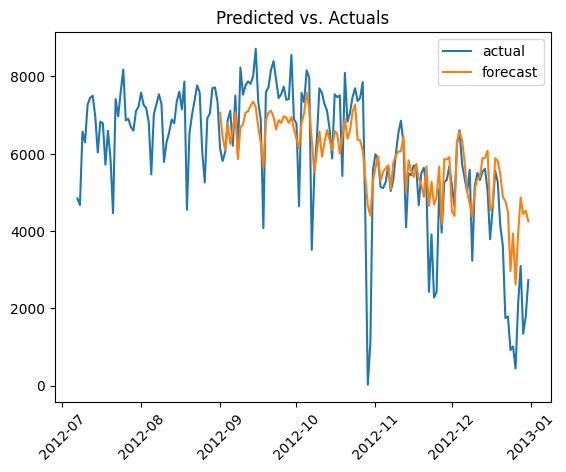

In [59]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.plot(df[[target_column_name, "predicted"]])
plt.xticks(rotation=45)
plt.title(f"Predicted vs. Actuals")
plt.legend(["actual", "forecast"])
plt.show()

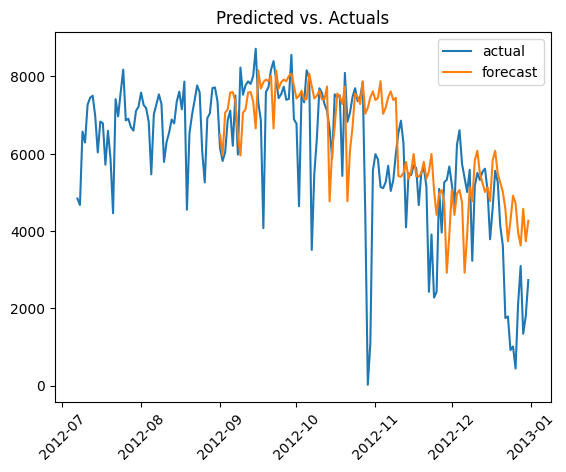

In [95]:
# Rolling forecast
%matplotlib inline
from matplotlib import pyplot as plt

plt.plot(df[[target_column_name, "predicted"]])
plt.xticks(rotation=45)
plt.title(f"Predicted vs. Actuals")
plt.legend(["actual", "forecast"])
plt.show()

In [69]:
from metrics_helper import calculate_metrics
calculate_metrics(fcst_df[target_column_name], fcst_df["predicted"])

,metric name,score
0,R2 score,0.618489
1,mean absolute error,883.329807
2,mean_absolute_percentage_error,202.552919
3,root mean squared error,1210.388743
4,normalized root mean squared error,0.139253
